# Housekeeping

In [90]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [91]:
!pip install plotly

# Data Gathering, Generating Features, Creating Train-Test Split

In [92]:

def get_data():
   
    Vol_Index = yf.download("^VIX", auto_adjust=True, period='20y')["Close"]
    SPY = yf.download("SPY", auto_adjust=True, period='20y')["Close"]
    SH = yf.download("SH", auto_adjust=True, period='20y')["Close"]
    VolVol_Index = yf.download("^VVIX", auto_adjust=True, period='20y')["Close"]
    TenYearTNote = yf.download("^TNX", auto_adjust=True, period='20y')["Close"]

    df = pd.concat([Vol_Index, SPY, SH, VolVol_Index, TenYearTNote], axis=1)
    df.columns = ['Vol_Index', 'SPY', 'SH', 'VolVol_Index', 'TenYearTNote']

    return df.dropna()


def get_features(df):
    # Daily Returns
    df['VIX_ret_1d'] = df['Vol_Index'].pct_change()
    df['SPY_ret_1d'] = df['SPY'].pct_change()
    df['SH_ret_1d'] = df['SH'].pct_change()  # Add SH return

    # Technical Indicators for VIX
    df['VIX_SMA20'] = df['Vol_Index'].rolling(20).mean() #Indicates if VIX is elevated or depressed
    df['VIX_ratio'] = df['Vol_Index'] / df['VIX_SMA20'] #Suggests that VIX might be high compared to recent history if greater than 1 
    df['VIX_std20'] = df['Vol_Index'].rolling(20).std() #Measures the volatility of its volatility, higher values might imply whether VIX is unstable or erratic

    # Spread Features
    df['VIX_VVIX_spread'] = df['Vol_Index'] - df['VolVol_Index']  #Spread between VIX and VVIX, larger spread often precedes spikes in market fear
    df['TNX_ret_1d'] = df['TenYearTNote'].pct_change()  #10yr treasury yield return - Captures Macro Sentiment 

    # Will VIX Rise Tomorrow?
    df['VIX_direction'] = (df['Vol_Index'].shift(-1) > df['Vol_Index']).astype(int) #Predicting whether VIX will increase using above features

    return df.dropna()


def get_features_train_test_split(df):
    features = ['VIX_ret_1d', 'SPY_ret_1d', 'VIX_ratio', 'VIX_std20', 'VIX_VVIX_spread', 'TNX_ret_1d']
    input_data = df[features].dropna()
    target_variable = df.loc[input_data.index, 'VIX_direction']

    X_train, X_test, y_train, y_test = train_test_split(input_data, target_variable, train_size=0.8, shuffle=False)

    return X_train, X_test, y_train, y_test

# Training Model, Summarising Performance 

In [93]:
def train_model(X_train, y_train):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_proba 

def model_performance_summary(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    
    print("=== Model Classification Report ===")
    print(classification_report(y_test, y_pred))
    
    accuracy = report['accuracy']
    print(f"• Overall accuracy: {accuracy:.2%}\n")
    
    for cls in ['0', '1']:
        precision = report[cls]['precision']
        recall = report[cls]['recall']
        f1 = report[cls]['f1-score']
        support = report[cls]['support']
        
        if cls == '0':
            print("• Class '0' (VIX does NOT rise next day):")
            print(f"  - Precision: {precision:.2%} (Correctness of 'no-rise' predictions)")
            print(f"  - Recall: {recall:.2%} (How many actual 'no-rise' days identified)")
            print(f"  - F1-score: {f1:.2%} (Balance of precision & recall)")
        else:
            print("• Class '1' (VIX RISES next day):")
            print(f"  - Precision: {precision:.2%} (Correctness of 'rise' predictions)")
            print(f"  - Recall: {recall:.2%} (How many actual rises identified)")
            print(f"  - F1-score: {f1:.2%} (Balance of precision & recall)")
        
        print(f"  - Sample count: {support}\n")
    
    # Now plot summary tables and confusion matrix
    plot_classification_report(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred)


def plot_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    classes = ['0', '1']
    headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
    rows = []
    for cls in classes:
        rows.append([
            f"Class {cls}",
            f"{report[cls]['precision']:.2%}",
            f"{report[cls]['recall']:.2%}",
            f"{report[cls]['f1-score']:.2%}",
            f"{int(report[cls]['support'])}"
        ])

    fig = go.Figure(data=[go.Table(
        header=dict(values=headers, fill_color='paleturquoise', align='left'),
        cells=dict(values=list(zip(*rows)), fill_color='lavender', align='left'))
    ])
    fig.update_layout(title_text="Classification Report Summary")
    fig.show()


def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['Predicted 0', 'Predicted 1']
    
    z_text = [[f"{value:.2f}" for value in row] for row in cm]
    fig = ff.create_annotated_heatmap(
        z=cm,
        x=labels,
        y=labels,
        annotation_text=z_text,
        colorscale='Blues',
        showscale=True
    )
    fig.update_layout(
        title="Normalized Confusion Matrix (Row-wise)",
        xaxis_title="Predicted",
        yaxis_title="Actual"
    )
    fig.show()

# Calibrating to Find the Optimal Strategy

In [94]:
def find_best_threshold(df, X_test, y_proba):
    df = df.copy()
    df['SPY_ret_1d'] = df['SPY'].pct_change()
    thresholds = np.arange(0.3, 0.6, 0.025)
    returns = []

    for t in thresholds:
        df['position'] = 0
        df.loc[X_test.index, 'position'] = np.where(y_proba > t, 1, -1)
        df['strategy_ret'] = df['position'].shift(1) * df['SPY_ret_1d']
        cumulative = (1 + df['strategy_ret']).cumprod()
        returns.append(cumulative.dropna().iloc[-1])

    plt.figure(figsize=(10, 2))
    sns.heatmap([returns], xticklabels=[f"{th:.3f}" for th in thresholds], cmap="RdYlGn", annot=True, fmt=".4f")
    plt.title("Strategy Final Returns by Threshold")
    plt.xlabel("Threshold")
    plt.yticks([], [])
    plt.show()

    best_idx = np.argmax(returns)
    best_threshold = thresholds[best_idx]
    print(f"Best threshold found: {best_threshold:.3f} with final return {returns[best_idx]:.4f}\n")
    return best_threshold

def backtest_strategy(df, X_test, y_proba, threshold):
    df = df.copy()
    df['SPY_ret'] = df['SPY'].pct_change()
    start_date = X_test.index[0]
    df = df.loc[start_date:]

    df['position'] = 0
    df.loc[X_test.index, 'position'] = np.where(y_proba > threshold, 1, -1)

    df['strategy_ret'] = df['position'].shift(1) * df['SPY_ret']
    df['cumulative_strategy'] = (1 + df['strategy_ret']).cumprod()
    df['cumulative_spy'] = (1 + df['SPY_ret']).cumprod()
    return df

def annotate_macro_events(ax, y_pos_ratio=0.95):
    macro_events = {
        "2022-01-24": ("Tech Drawdown", "gray"),
        "2022-03-16": ("1st Fed Hike", "red"),
        "2022-06-13": ("CPI Shock", "red"),
        "2022-09-21": ("Dot Plot Surprise", "red"),
        "2022-10-13": ("CPI Reversal", "green"),
        "2023-03-10": ("SVB Collapse", "black"),
        "2023-10-19": ("10Y @ 5%", "gray"),
        "2024-03-20": ("No Rate Cut", "orange"),
        "2024-07-05": ("NFP Beat", "blue"),
        "2024-11-05": ("Election Volatility / Trump Rally", "purple"),
        "2025-02-01": ("China Crash", "black"),
        "2025-04-07": ("Tariff Bear Market", "black"),
        "2025-07-21": ("Profit Shock Report", "orange"),
    }

    ylim_top = ax.get_ylim()[1]

    for date_str, (label, color) in macro_events.items():
        date = pd.to_datetime(date_str)
        ax.axvline(date, color=color, linestyle='--', alpha=0.6, linewidth=1)
        ax.text(
            date, ylim_top * y_pos_ratio, label,
            rotation=90, verticalalignment='top', fontsize=8, color=color,
            backgroundcolor='white', alpha=0.9
        )

        
def plot_backtest_results(df):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index, y=df['cumulative_strategy'],
        mode='lines', name='Strategy',
        line=dict(color='dodgerblue', width=2)
    ))

    fig.add_trace(go.Scatter(
        x=df.index, y=df['cumulative_spy'],
        mode='lines', name='SPY (Buy & Hold)',
        line=dict(color='orange', width=2)
    ))

    macro_events = {
        "2022-01-24": "Tech Drawdown",
        "2022-03-16": "1st Fed Hike",
        "2022-06-13": "CPI Shock",
        "2022-09-21": "Dot Plot Surprise",
        "2022-10-13": "CPI Reversal",
        "2023-03-10": "SVB Collapse",
        "2023-10-19": "10Y @ 5%",
        "2024-03-20": "No Rate Cut",
        "2024-07-05": "NFP Beat",
        "2024-11-05": "Election Volatility",
        "2025-02-01": "China Crash",
        "2025-04-07": "Tariff Bear Market",
        "2025-07-21": "Profit Shock Report"
    }

    for date_str, label in macro_events.items():
        date = pd.to_datetime(date_str)
        if date in df.index:
            fig.add_vline(x=date, line=dict(color='black', width=1, dash='dot'))
            fig.add_annotation(
                x=date,
                y=max(df['cumulative_strategy'].max(), df['cumulative_spy'].max()) * 1.02,
                text=label,
                showarrow=False,
                yanchor='bottom',
                textangle=-90,
                font=dict(size=10, color='black'),
                xanchor='left'
            )

  
    fig.update_layout(
        title="Cumulative Returns: Macro Strategy vs SPY",
        xaxis_title="Date",
        yaxis_title="Cumulative Return",
        hovermode="x unified",
        template="plotly_white",
        legend=dict(x=0.99, y=0.01),
        margin=dict(t=60, b=40, l=60, r=40)
    )

    fig.show()


# Summarising Performance, Running Code

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=== Model Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.91      0.70       528
           1       0.47      0.11      0.18       400

    accuracy                           0.56       928
   macro avg       0.52      0.51      0.44       928
weighted avg       0.53      0.56      0.48       928

• Overall accuracy: 56.25%

• Class '0' (VIX does NOT rise next day):
  - Precision: 57.31% (Correctness of 'no-rise' predictions)
  - Recall: 90.53% (How many actual 'no-rise' days identified)
  - F1-score: 70.19% (Balance of precision & recall)
  - Sample count: 528.0

• Class '1' (VIX RISES next day):
  - Precision: 46.81% (Correctness of 'rise' predictions)
  - Recall: 11.00% (How many actual rises identified)
  - F1-score: 17.81% (Balance of precision & recall)
  - Sample count: 400.0



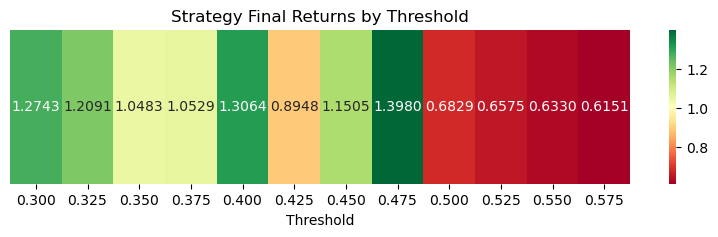

Best threshold found: 0.475 with final return 1.3980

Backtesting with best threshold 0.475:


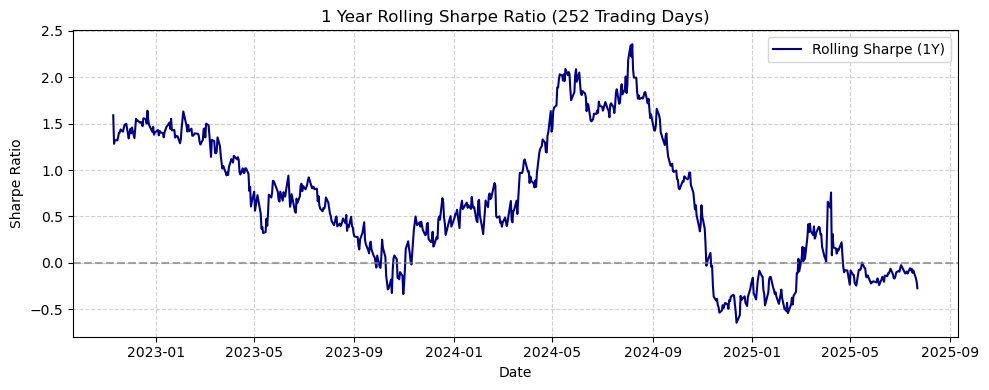

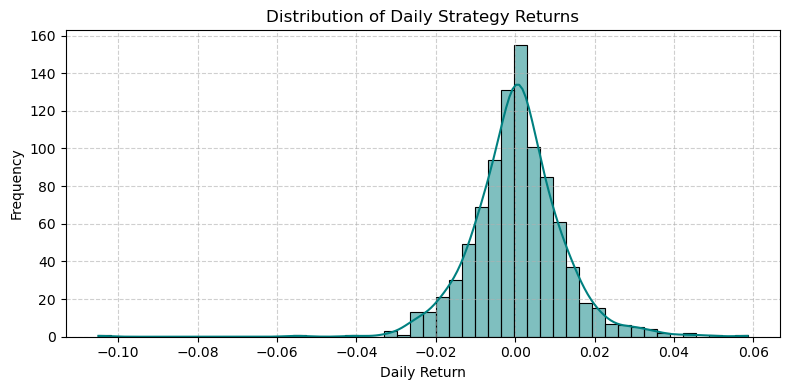

In [95]:
def strategy_performance_summary(df):
    cumulative_return = df['cumulative_strategy'].iloc[-1] - 1
    total_days = len(df.dropna())
    annual_factor = 252

    annualized_return = (df['cumulative_strategy'].iloc[-1]) ** (annual_factor / total_days) - 1
    strat_ret = df['strategy_ret'].dropna()
    sharpe_ratio = strat_ret.mean() / strat_ret.std() * np.sqrt(annual_factor)

    running_max = df['cumulative_strategy'].cummax()
    drawdown = (df['cumulative_strategy'] - running_max) / running_max
    max_drawdown = drawdown.min()

    spy_return = df['cumulative_spy'].iloc[-1] - 1
    spy_cagr = df['cumulative_spy'].iloc[-1] ** (annual_factor / total_days) - 1
    spy_ret = df['SPY'].pct_change()
    spy_sharpe = spy_ret.mean() / spy_ret.std() * np.sqrt(annual_factor)

    spy_running_max = df['cumulative_spy'].cummax()
    spy_drawdown = (df['cumulative_spy'] - spy_running_max) / spy_running_max
    spy_max_drawdown = spy_drawdown.min()

    print("=== Strategy Performance Summary ===")
    print(f"Total Return: {cumulative_return*100:.2f}%")
    print(f"Annualized Return (CAGR): {annualized_return*100:.2f}%")
    print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%\n")
    print(f"SPY Total Return (Buy & Hold): {spy_return*100:.2f}%")
    print(f"SPY Annualized Return (CAGR): {spy_cagr*100:.2f}%")
    print(f"SPY Sharpe Ratio (annualized): {spy_sharpe:.2f}")
    print(f"SPY Max Drawdown: {spy_max_drawdown*100:.2f}%")

def plot_rolling_sharpe_plotly(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df.index, y=df['rolling_sharpe'],
        mode='lines',
        name='Rolling Sharpe Ratio',
        line=dict(color='royalblue')
    ))
    fig.update_layout(
        title="Rolling Sharpe Ratio",
        xaxis_title="Date",
        yaxis_title="Sharpe Ratio",
        template="plotly_white"
    )
    fig.show()

def plot_return_distribution_plotly(df):
    fig = px.histogram(df, x='strategy_ret', nbins=50, title="Strategy Daily Return Distribution",
                       labels={"strategy_ret": "Daily Return"})
    fig.update_layout(template="plotly_white")
    fig.show()


def plot_feature_importance_logreg(model, feature_names):
    # Extract coefficients (assumes binary classification)
    coefs = model.coef_[0]
    df_imp = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs
    }).sort_values(by="Coefficient")
    
    # Color by sign: positive (blue), negative (red)
    df_imp['Color'] = df_imp['Coefficient'].apply(lambda x: 'blue' if x > 0 else 'red')
    
    fig = px.bar(
        df_imp,
        x="Coefficient",
        y="Feature",
        orientation='h',
        title="Feature Importance (Logistic Regression Coefficients)",
        color='Color',
        color_discrete_map={'blue': 'blue', 'red': 'red'},
        labels={"Coefficient": "Coefficient Value", "Feature": "Feature"}
    )
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig.show()

def main():
    df = get_data()
    df = get_features(df)
    X_train, X_test, y_train, y_test = get_features_train_test_split(df)

    model = train_model(X_train, y_train)
    y_pred, y_proba = evaluate_model(model, X_test, y_test)
    model_performance_summary(y_test, y_pred)

    best_thresh = find_best_threshold(df.copy(), X_test, y_proba)
    print(f"Backtesting with best threshold {best_thresh:.3f}:")
    df_backtest = backtest_strategy(df.copy(), X_test, y_proba, best_thresh)
    
    plot_backtest_results(df_backtest)         # Matplotlib backtest plot (optional if you want)
    plot_rolling_sharpe(df_backtest)
    plot_return_distribution(df_backtest)
    plot_feature_importance_logreg(model, X_train.columns)  # Plotly logistic regression feature importance
    plot_backtest_plotly(df_backtest)          # Plotly backtest plot

main()